# Introduction to PyTorch and PyTorch Lightning

## What is PyTorch?

PyTorch is an open-source deep learning framework developed by Facebook's AI Research lab (FAIR). It provides a flexible and intuitive interface for building and training neural networks, with strong support for dynamic computational graphs. This makes it particularly useful for applications requiring variable input sizes or complex architectures, such as Natural Language Processing (NLP), computer vision, and reinforcement learning.

PyTorch's popularity in both research and industry stems from its ease of use, extensive library support, and the seamless transition it offers from research prototyping to production deployment. It supports Python as its primary language and integrates well with popular Python libraries like NumPy, making it a go-to tool for many AI practitioners.

## What is PyTorch Lightning?

PyTorch Lightning is a lightweight, high-level framework built on top of PyTorch. It abstracts much of the boilerplate code associated with training and testing deep learning models, providing a more organized and reproducible approach to model development. PyTorch Lightning structures code in a way that enhances readability, facilitates debugging, and makes it easier to scale and deploy models.

Key features of PyTorch Lightning include:
  - **Abstraction of Boilerplate Code**: Handles common tasks like training loops, logging, and device management.
  - **Scalability**: Simplifies the process of scaling models across multiple GPUs, nodes, or TPUs.
  - **Reproducibility**: Ensures consistency across runs, making experiments more reliable.
  - **Flexibility**: Maintains PyTorch’s flexibility, allowing custom model architectures and complex workflows.

## Comparison to TensorFlow

TensorFlow, developed by Google, is another leading deep learning framework known for its robust production capabilities and comprehensive ecosystem, including tools like TensorFlow Extended (TFX) for deploying machine learning models at scale.

While both PyTorch and TensorFlow offer strong support for developing neural networks, PyTorch is often preferred for research and experimentation due to its ease of use.

PyTorch Lightning further abstracts the PyTorch framework, streamlining the coding process and reducing boilerplate, similar to TensorFlow's Keras API, which provides a high-level interface for building models.

Despite these differences, both ecosystems are widely used in academia and industry, with PyTorch gaining increasing popularity in research settings for its ease of use and TensorFlow maintaining a strong presence in production environments due to its mature tooling and deployment capabilities.

## Intro to Lightning

Let's first import all necessary libraries.

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 23.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import optim, nn
import torch.nn.functional as F
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import BinaryAccuracy

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

We'll start with a dummy dataset so that we can better understand the results.

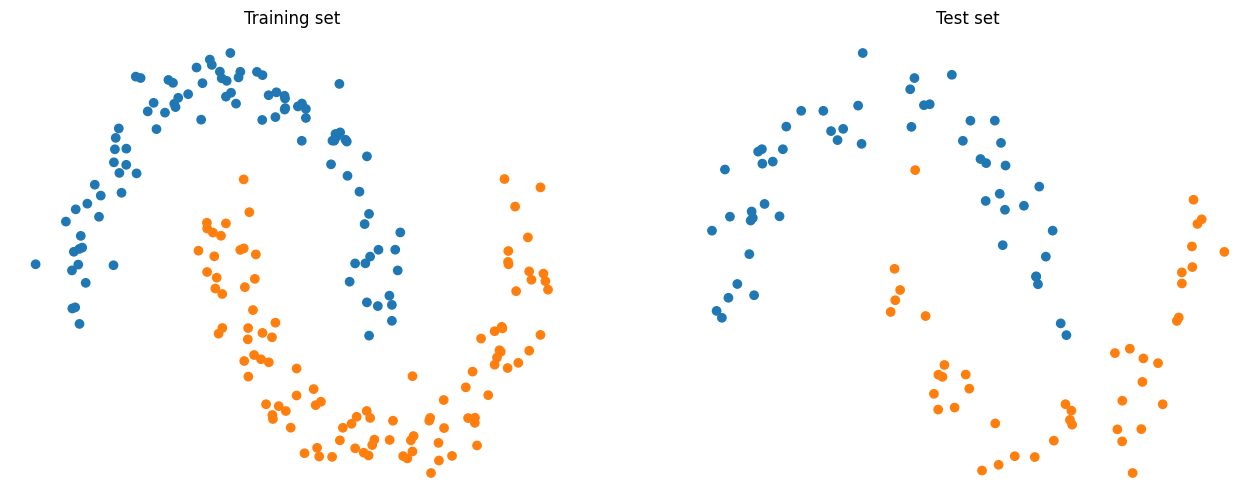

In [ ]:
np.random.seed(13)

X, y = make_moons(300, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(16, 6))

ax = plt.subplot(121)
colors = ['C' + str(i) for i in y_train]
ax.scatter(X_train[:, 0], X_train[:, 1], c=colors)
ax.axis('off')
ax.set_title('Training set')

ax = plt.subplot(122)
colors = ['C' + str(i) for i in y_test]
ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)
ax.axis('off')
ax.set_title('Test set');

In this tutorial we'll attempt to introduce PyTorch Lightning's basic functionality through various endeavors to solve the aforementioned moons problem. These endeavours will be presented as case studies, through which build increasingly more complex approaches.

##Case study 1: Logistic Regression

### Building a model

Let's start of by creating our first model. To keep this simple we'll start by training a simple 1-layer Neural Network, which is essentially a logistic regression model. This model essentially performs the operation:

$$
\hat y = \sigma (X \cdot W + b)
$$

where $\hat y$ are the model's predictions, $\sigma$ is the sigmoid function, $W$ is a matrix of parameters, referred to as weights, $X$ are the inputs and $b$ are another set of parameters called biases.

We can perform this operation with two ways. The first would be to manually create the parameter arrays $W$ and $b$ and then manually define the operation. This would look something like this:

```python
weights = torch.randn(2, 1)
weights.requires_grad_()
biases = torch.zeros(1, requires_grad=True)


def sigmoid(z):
    return 1 / (1 + torch.exp(-z))


def logistic_regression(x):
    return sigmoid(x @ weights + bias)
```

While this approach might work for such a simple network, it is not scalable for larger ones; we cannot be expected to build a network with dozens of layers this way. Luckily for us, PyTorch has defined some classes that implement some commonly used operations (such as the affine transformation $W \cdot X + b$ mentioned above). All of these can be found in the [torch.nn](https://pytorch.org/docs/stable/nn.html) module. This module has all necessary building blocks for defining and training neural networks.

We can build our logistic regressor through the combination of PyTorch's [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) and [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) classes.

In [ ]:
class LogisticRegression(L.LightningModule):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Define what happens in the forward step of the network
        """
        return self.sigmoid(self.linear(x))

    def training_step(self, batch, batch_idx):
        """
        Define a training step. This includes:
          - how the inputs are passed to the network
          - the forward propagation
          - the comutation of the loss
        """
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        return loss

    def configure_optimizers(self, lr=0.1):
        """
        Initialize the optimizer that will be used to train the network
        """

        # Here we'll use an SGD optimizer (the simplest optimizer we could use), with its default LR
        optimizer = optim.SGD(self.parameters(), lr=lr)
        return optimizer


log_reg = LogisticRegression(input_dim=2, output_dim=1)

One thing we need to explicitly tell define when building our model, are the dimensions of our inputs and outputs. It doesn't care about how many samples we have, rather how many **features** the input has. In our case, we have $2$ input features and $1$ output (because we are dealing with binary classification). The architecture we followed can be seen in the figure below:

![](https://github.com/djib2011/tensorflow-training/blob/main/figures/logistic_regression.png?raw=true)


With this `LogisticRegression` class we will represent our neural network. At the moment, we've just defined the model, but it is still **untrained**. Let's try to see our model's performance before training. We'll do this in two ways:

1. We'll measure our model's accuracy on the test set
2. We'll visualize our model's decision boundary on the data

*Note: Below, the code denoted as PLOTTING is a function that will help us visualize our model's performance. It doesn't have anything to do with PyTorch or Lightning, so it is not necessary to understand how it works in order to continue with this notebook.*

accuracy: 34.34343434343434%


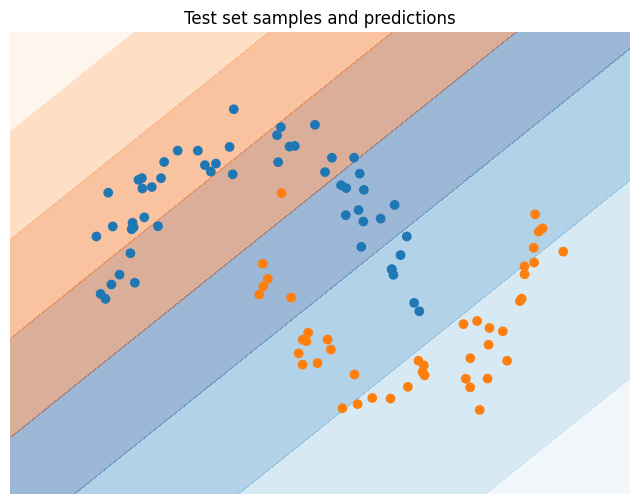

In [ ]:
######################################################################
############################## PLOTTING ##############################
######################################################################

def visualize_decision_boundary(model):
    """
    Helper function that visualizes a model's decision boundary on the
    previously defined moons dataset
    """
    # Find out where to start and end the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    # Generate the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05, dtype=np.float32),
                         np.arange(y_min, y_max, 0.05, dtype=np.float32))

    # Generate predictions for each point of the mesh
    with torch.no_grad():
        mesh_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
        mesh_preds = model(mesh_tensor).numpy()

    # We'll also create a custom diverging colormap from blue to orange.
    # Details here:
    # https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

    blue = matplotlib.colormaps['Blues']
    orange = matplotlib.colormaps['Oranges_r']

    color_array = np.vstack((blue(np.linspace(0, 1, 128)),
                             orange(np.linspace(0, 1, 128))))

    BuOr = matplotlib.colors.ListedColormap(color_array)

    # Create the figure
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    # Draw the mesh predictions as contours
    ax.contourf(xx, yy, mesh_preds.reshape(xx.shape), cmap=BuOr, alpha=0.4)

    # Draw the data points in their actual colors
    colors = ['C' + str(int(i)) for i in y_test]
    ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)

    ax.axis('off')
    ax.set_title('Test set samples and predictions')


######################################################################
################################ CODE ################################
######################################################################

# Get the model's predictions
with torch.no_grad():
    preds = log_reg(torch.from_numpy(X_test).float())  # it is necessary first to convert to tensor

# Convert predictions to binary and compute the accuracy
preds_binary = np.where(preds.numpy().flatten() > 0.5, 1, 0)
print(f'accuracy: {accuracy_score(y_test, preds_binary)*100}%')

# Call the helper function to visualize the decision boundary
visualize_decision_boundary(log_reg)

We can also see which samples were misclassified if we want.

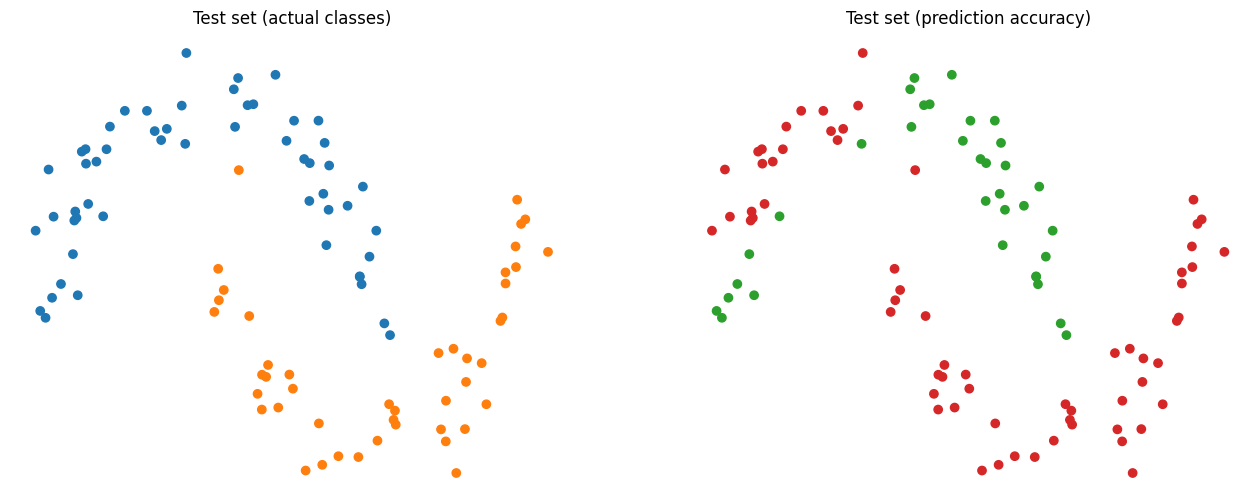

In [ ]:
######################################################################
############################## PLOTTING ##############################
######################################################################
plt.figure(figsize=(16, 6))

ax = plt.subplot(121)
colors = ['C' + str(i) for i in y_test]
ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)
ax.axis('off')
ax.set_title('Test set (actual classes)');

ax = plt.subplot(122)
colors = ['C2' if p else 'C3' for p in (preds_binary == y_test).astype(int) ]
ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)
ax.axis('off')
ax.set_title('Test set (prediction accuracy)');

### Training

Before doing anything else we'll need a way to better represent our data and feed it into our model. To do this we'll create a [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). The latter is essentially a data generator for loading the data and feeding it into the model.

For the time being we won't look deeper into these components but if you want a more in depth look into torch datasets and data loaders you can look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [ ]:
# Convert our arrays to tensors
x_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create the Dataset and DataLoader
dataset = TensorDataset(x_tensor, y_tensor.unsqueeze(1))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Also do the same thing for the test set
x_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.unsqueeze(1))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

To train the model we just need to create a [`Trainer`](https://lightning.ai/docs/pytorch/stable/common/trainer.html) object. This object automates all of the training process and helps us other things (e.g. validation).

In [ ]:
trainer = L.Trainer(max_epochs=5)

trainer.fit(model=log_reg, train_dataloaders=train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | linear  | Linear  | 3      | train
1 | sigmoid | Sigmoid | 0      | train
--------------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | linear  | Linear  | 3      | train
1 | sigmoid | Sigmoid | 0      | train
--------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


### Evaluation

We trained our logistic regression model. Let's see how well it does in our task like we did before training it.


accuracy: 67.67676767676768%
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        54
           1       0.64      0.67      0.65        45

    accuracy                           0.68        99
   macro avg       0.67      0.68      0.68        99
weighted avg       0.68      0.68      0.68        99



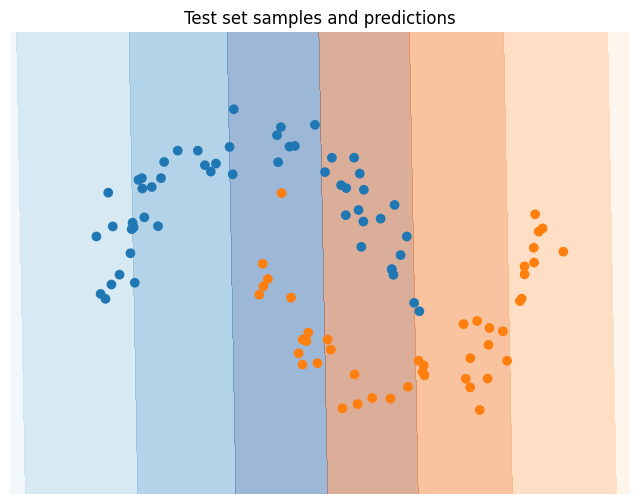

In [ ]:
# Get the model's predictions and convert them to binary
with torch.no_grad():
    preds = log_reg(x_val_tensor)
preds_binary = (preds.numpy().flatten() > 0.5).astype(int)

# Besides the accuracy, also print the classification report this time
print(f'accuracy: {accuracy_score(y_test, preds_binary)*100}%')
print(classification_report(y_test, preds_binary))

# Visualize the decision boundary
visualize_decision_boundary(log_reg)

Clearly it's doing much better than it was when it was still untrained.

## Case Study 2: Multi-Layer Perceptron

The main limitation of our previous model is its *capacity*. A linear model simply cannot separate these non-linear
data. To address this we'll add a second **hidden** layer to the network. This 2-layer Neural Network is referred to as a Multi-Layer Perceptron (MLP).

In [ ]:
class MultiLayerPerceptron(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        x = self.sigmoid(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Define what happens for each batch during validation.

        This should compute all relevant metrics and return a dictionary with them.
        """
        x, y = batch
        preds = self(x)
        preds_binary = (preds >= 0.5).int()
        loss = F.binary_cross_entropy(preds, y)
        acc = self.accuracy(preds_binary, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self, lr=0.1):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        return optimizer


mlp = MultiLayerPerceptron(input_dim=2, hidden_dim=3, output_dim=1)

The structure to the network is similar to what we built before, but between the input and output layers we added a new layer. Because of the non-linear natuer of this layer (due to the sigmoid activation), this network can now model non-linear relationships between input and output.

As we stated before, the input and output shapes are dictated by the problem we have to solve. However, the size of the hidden layer (i.e. $3$ in our case) is a **design choice**. The higher the value, the more parameters our network will have and the more complex functions it can model, which essentially will increase its capacity! This, along with the number of hidden layers and even the activations on these hidden layers.

### MLP Architecture Details

The architecure we created can be seen in the figure below:

![](https://github.com/djib2011/tensorflow-training/blob/main/figures/mlp.png?raw=true)

Our MLP has $13$ total parameters ($9$ in the hidden layer and $4$ in the output). Where do these numbers come from?

Essentially our MLP, performs the following operation:

$$
h = \sigma (X \cdot W_h + b_h) \\
\hat y = \sigma (h \cdot W_o + b_o)
$$

where: $X$ is the input, $W_h$ and $b_h$ are the weights and biases of the hidden layer and $W_o, b_o$ are the respective weights and biases of the output layer.

- Since we selected the hidden layer to have $3$ neurons, $W_h$ has a shape of $2 \times 3 = 6$ and $b_h$ has a shape of $3$, in total $9$ trainable parameters for this layer.
- The output layer sees the output of the hidden layer as its input (i.e. an input dim of $3$). As such, $W_o$ has a shape of $3 \times 1 = 3$ and $b_o$ has a shape of $1$, in total $4$ trainable parameters for this layer.

### Train and evaluate the MLP

Let's see if we can improve our performance with this architectural tweak

In [ ]:
trainer = L.Trainer(max_epochs=50)

trainer.fit(model=mlp, train_dataloaders=train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | hidden   | Linear         | 9      | train
1 | output   | Linear         | 4      | train
2 | sigmoid  | Sigmoid        | 0      | train
3 | accuracy | BinaryAccuracy | 0      | train
----------------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Let's see if the new model is better than the previous.

accuracy: 83.83838383838383%
              precision    recall  f1-score   support

           0       0.90      0.80      0.84        54
           1       0.78      0.89      0.83        45

    accuracy                           0.84        99
   macro avg       0.84      0.84      0.84        99
weighted avg       0.85      0.84      0.84        99



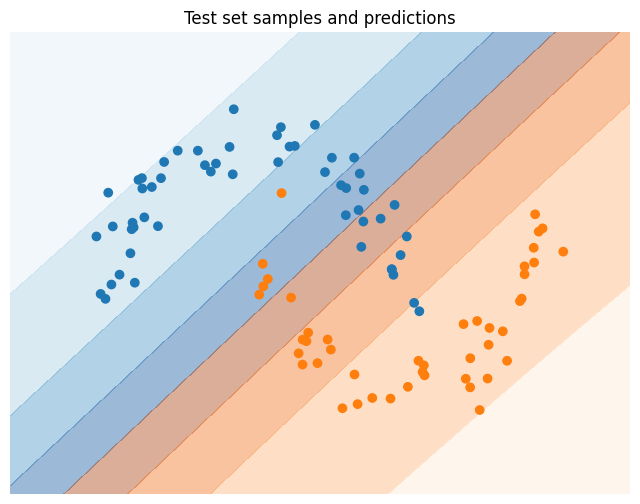

In [ ]:
# Get the model's predictions and convert them to binary
with torch.no_grad():
    preds = mlp(x_val_tensor)
preds_binary = (preds.numpy().flatten() > 0.5).astype(int)

# Besides the accuracy, also print the classification report this time
print(f'accuracy: {accuracy_score(y_test, preds_binary)*100}%')
print(classification_report(y_test, preds_binary))

# Visualize the decision boundary
visualize_decision_boundary(mlp)

Since we implemented the `validation_step` method in our model, we can now use the `validate` method of the trainer, which is more convenient.

In [ ]:
trainer.validate(model=mlp, dataloaders=val_loader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8383838534355164     │
│         val_loss          │    0.4213756322860718     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.4213756322860718, 'val_acc': 0.8383838534355164}]

If we look at the decision boundary we'll notice that, interestingly, even though we added a non-linear hidden layer, our model wasn't able to learn more than a linear relationship on the data.

## Case Study 3: Fine-tuned MLP architecture

We'll now try to make some architectural changes to our MLP so that it can actually achieve what we wanted, i.e. be able to learn a non-linear function.

### Increase capacity

First, we'll try increasins the size of the hidden layer so that our network can model more complex functions.

Since we made our model have a configurable `hidden_dim`, we won't need to re-define the MLP, just instantiate a new one!

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | hidden   | Linear         | 90     | train
1 | output   | Linear         | 31     | train
2 | sigmoid  | Sigmoid        | 0      | train
3 | accuracy | BinaryAccuracy | 0      | train
----------------------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.868686854839325     │
│         val_loss          │    0.30500876903533936    │
└───────────────────────────┴───────────────────────────┘

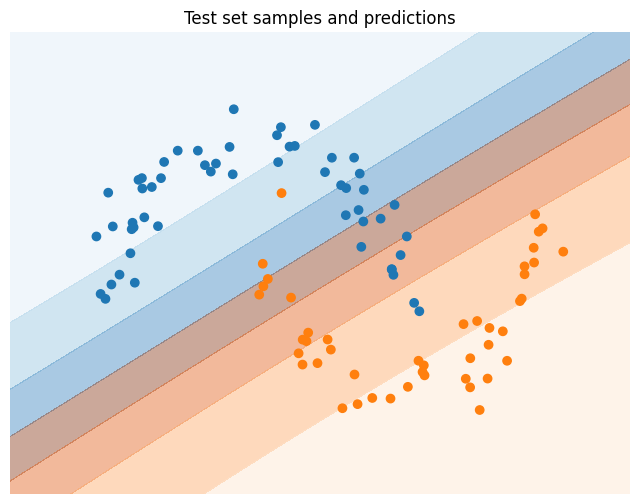

In [ ]:
mlp2 = MultiLayerPerceptron(input_dim=2, hidden_dim=30, output_dim=1)

trainer = L.Trainer(max_epochs=50)
trainer.fit(model=mlp2, train_dataloaders=train_loader)

trainer.validate(model=mlp2, dataloaders=val_loader)

visualize_decision_boundary(mlp2)

### Change hidden layer activation

We'll start by changing the sigmoid activation of the hidden layer to another non-linear function, [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

*Note: We can't change the output layer activation, because that has to do with the fact that we're solving a binary classification problem*

Since we'll be reusing a lot of functionality from the previous model, we won't write everything from scratch. We'll just define a subclass and overwrite the forward propagation to change the activation functions.

In [ ]:
class MultiLayerPerceptronRelu(MultiLayerPerceptron):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__(input_dim, hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | hidden   | Linear         | 90     | train
1 | output   | Linear         | 31     | train
2 | sigmoid  | Sigmoid        | 0      | train
3 | accuracy | BinaryAccuracy | 0      | train
4 | relu     | ReLU           | 0      | train
----------------------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summ

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9191918969154358     │
│         val_loss          │    0.22669470310211182    │
└───────────────────────────┴───────────────────────────┘

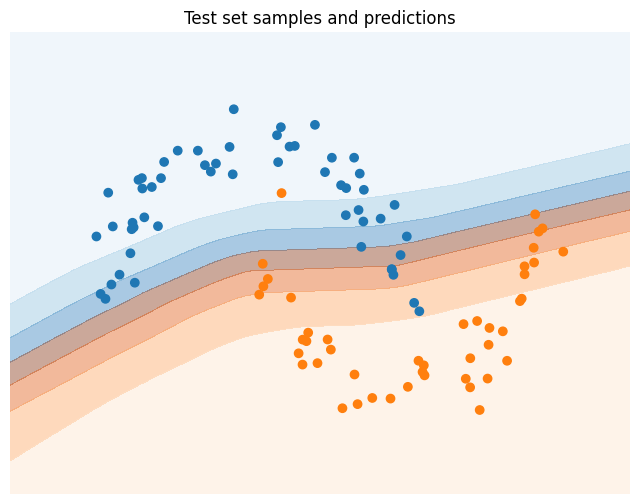

In [ ]:
mlp_relu = MultiLayerPerceptronRelu(input_dim=2, hidden_dim=30, output_dim=1)

trainer = L.Trainer(max_epochs=50)
trainer.fit(model=mlp_relu, train_dataloaders=train_loader)

trainer.validate(model=mlp_relu, dataloaders=val_loader)

visualize_decision_boundary(mlp_relu)

With these two changes, we can see both in the evaluation metrics and in the visualization that we are moving in the right direction. Our model is starting to learn the data better.

### Your turn

For exercise try to improve performance even more with the methods we've presented up till now. Some things you can try:

- Further increase the size of the hidden layer
- Allow the network to train for even longer
- Try adding another hidden layer (inp --> hid1 --> hid2 --> out)

With these changes you should be able to achieve an even stroner classification performance like the following:

![](https://github.com/djib2011/tensorflow-training/blob/main/figures/mlp_moons.png?raw=true)